In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [12]:
# Load the dataset
tsunami = pd.read_csv(r'C:\Users\ungdu\Downloads\Smart-Decision\Tsunami_Cut.csv')
tsunami.head()

,Year,Mo,Tsunami Event Validity,Tsunami Cause Code,Earthquake Magnitude,Vol,Deposits,Country,Location Name,Latitude,...,Damage ($Mil),Damage Description,Houses Destroyed,Houses Destroyed Description,Total Deaths,Total Death Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description
0,-2000,NaN,1,1.0,NaN,NaN,0,SYRIA,SYRIAN COASTS,35.683,...,NaN,4.0,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN
1,-1610,NaN,4,6.0,NaN,1351.0,28,GREECE,THERA ISLAND (SANTORINI),36.400,...,NaN,3.0,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN
2,-1365,NaN,1,1.0,NaN,NaN,0,SYRIA,SYRIAN COASTS,35.683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
3,-1300,NaN,2,0.0,6.0,NaN,0,TURKEY,"IONIAN COASTS, TROAD",39.960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-760,NaN,2,0.0,NaN,NaN,0,ISRAEL,ISRAEL AND LEBANON COASTS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Filter rows where the year is greater than 1800
tsunami_filtered = tsunami_cleaned[tsunami_cleaned['Year'] > 1800]


In [14]:
# Filter relevant columns
tsunami_filtered = tsunami_filtered[['Latitude', 'Longitude', 'Tsunami Cause Code']]

In [15]:
# Handle missing values in the filtered columns
tsunami_filtered = tsunami_filtered.dropna()

In [26]:
# Normalize the data
scaler = StandardScaler()
tsunami_normalized = scaler.fit_transform(tsunami_filtered)

In [27]:
# Step 2: Implementing Self-Organizing Maps (SOMs)
som_size = int(len(tsunami_normalized) ** 0.5)
som = MiniSom(som_size, som_size, tsunami_normalized.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(tsunami_normalized, 100)
def get_winner_coords(data, som):
    return np.array([som.winner(x) for x in data])
som_clusters = get_winner_coords(tsunami_normalized, som)

In [28]:
# Step 3: Implementing Autoencoders
input_dim = tsunami_normalized.shape[1]
encoding_dim = 2
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(tsunami_normalized, tsunami_normalized, epochs=50, batch_size=16, shuffle=True)
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_data = encoder_model.predict(tsunami_normalized)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2567 
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2274
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1943
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1262
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0550
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9629
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9193
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8559
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8626
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8354
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8132
Epoch 12/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.8464
Epoch 13/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8007
Epoch 14/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7966
Epoch 15/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

In [29]:
# Step 4: Clustering using SOMs and Autoencoders
combined_features = np.hstack((encoded_data, som_clusters))
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(combined_features)
tsunami_filtered['Cluster'] = clusters

In [30]:
# Step 5: Visualization on World Map using geopandas and contextily
gdf = gpd.GeoDataFrame(tsunami_filtered, geometry=gpd.points_from_xy(tsunami_filtered.Longitude, tsunami_filtered.Latitude))
gdf.set_crs(epsg=4326, inplace=True)

,Latitude,Longitude,Tsunami Cause Code,Cluster,geometry
611,45.300,14.400,9.0,0,POINT (14.40000 45.30000)
612,17.200,-62.400,1.0,1,POINT (-62.40000 17.20000)
614,10.300,-64.500,1.0,1,POINT (-64.50000 10.30000)
615,-3.700,128.200,1.0,1,POINT (128.20000 -3.70000)
616,45.700,26.600,1.0,3,POINT (26.60000 45.70000)
...,...,...,...,...,...
2856,-14.985,167.983,1.0,0,POINT (167.98300 -14.98500)
2857,8.527,126.449,1.0,1,POINT (126.44900 8.52700)
2858,-20.659,169.206,1.0,0,POINT (169.20600 -20.65900)
2859,37.498,137.242,3.0,0,POINT (137.24200 37.49800)


C:\Users\ungdu\AppData\Local\Temp\ipykernel_20884\2098609292.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\ungdu\AppData\Local\Temp\ipykernel_20884\2098609292.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  oceans = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


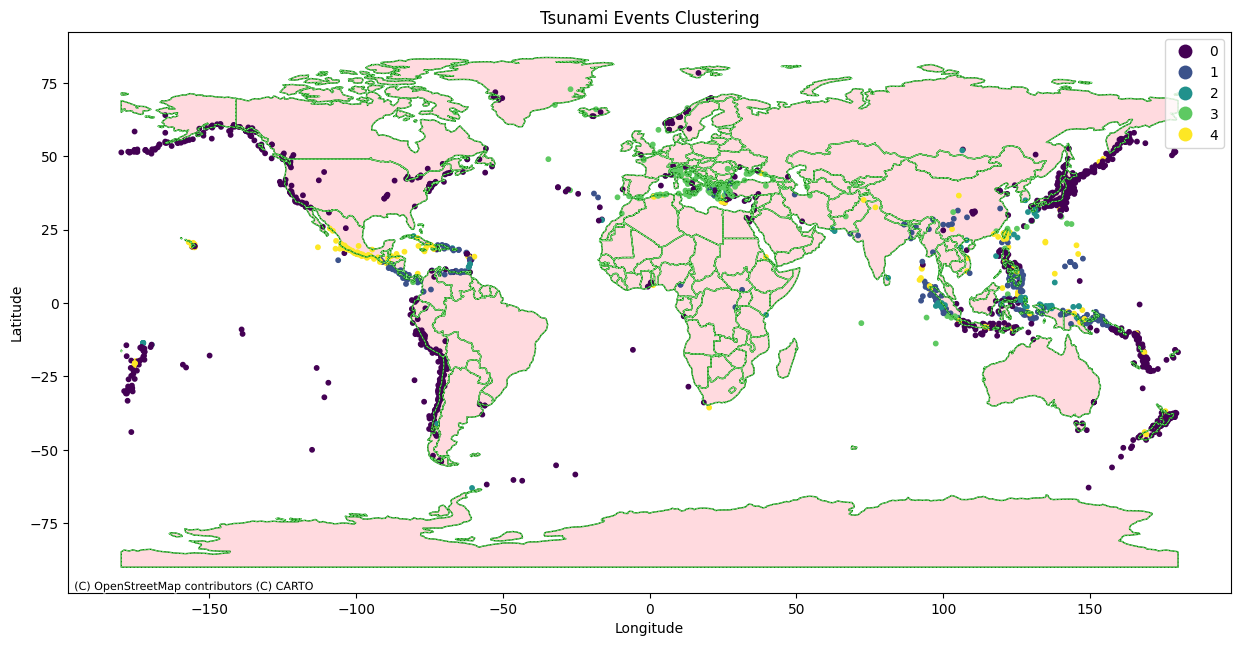

In [51]:
# Load Natural Earth features for continents and oceans
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
oceans = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title('Tsunami Events Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

     Latitude  Longitude  Tsunami Cause Code  Cluster
611     45.30      14.40                 9.0        0
618     37.70     138.30                 1.0        0
622     39.05     139.95                 1.0        0
625    -29.06     167.95                 0.0        0
627     34.40    -119.70                 1.0        0


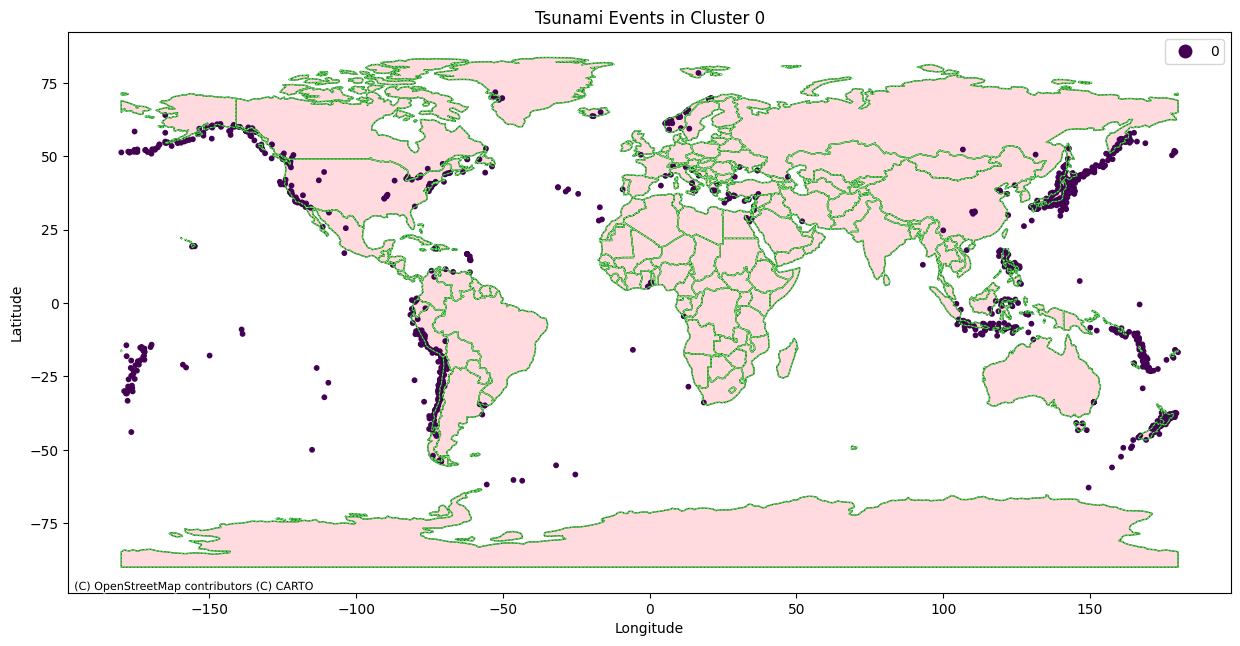

In [52]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 0  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

     Latitude  Longitude  Tsunami Cause Code  Cluster
612      17.2      -62.4                 1.0        1
614      10.3      -64.5                 1.0        1
615      -3.7      128.2                 1.0        1
637      14.0      143.3                 1.0        1
648      10.6      -66.9                 1.0        1


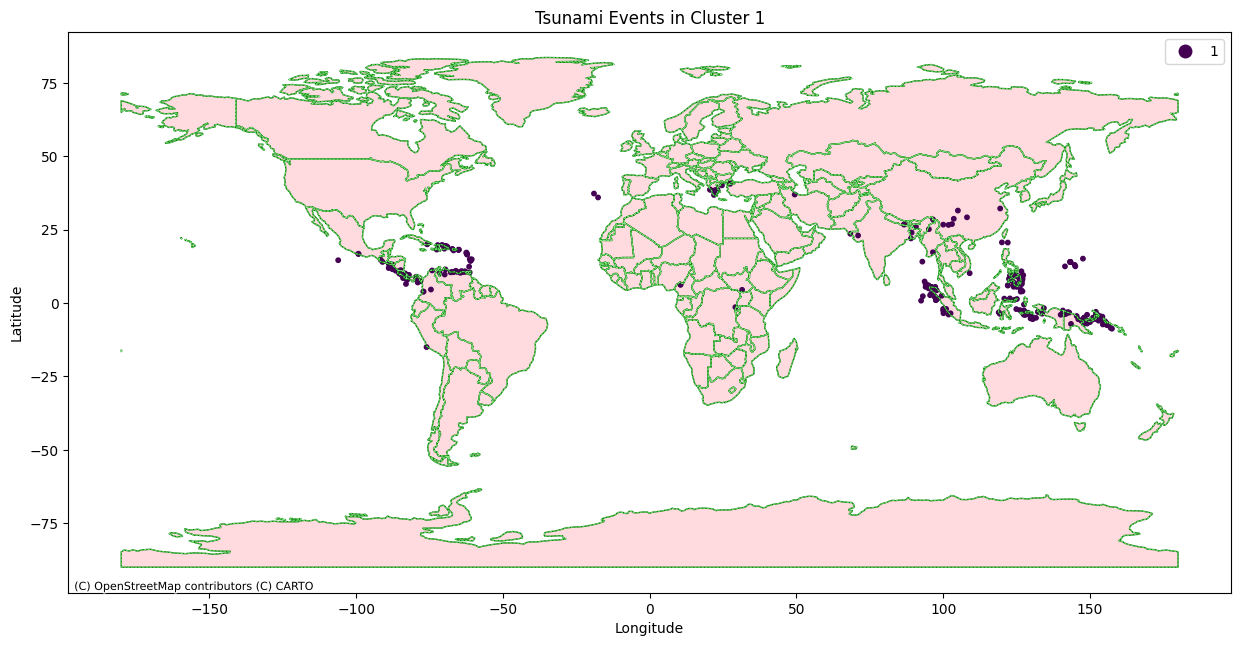

In [53]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 1  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

     Latitude  Longitude  Tsunami Cause Code  Cluster
670      -4.0    101.500                 3.0        2
775       0.8    127.325                 1.0        2
802       1.5    124.850                 1.0        2
810       2.0    126.500                 1.0        2
852      -5.0    105.000                 0.0        2


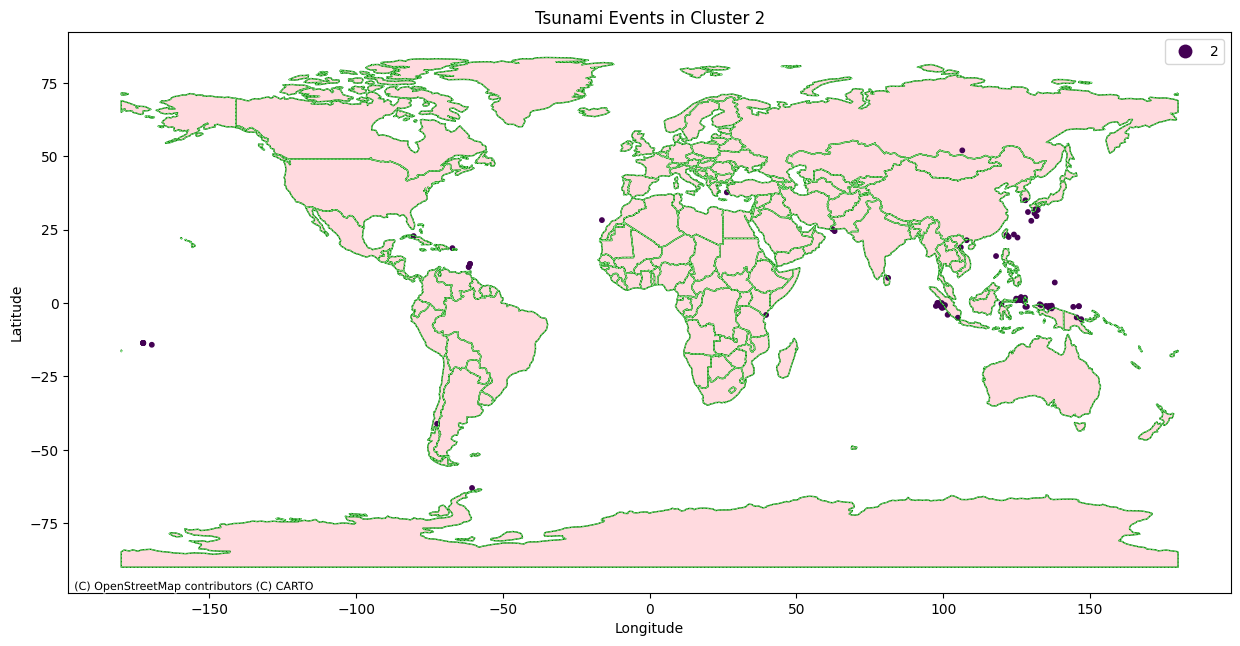

In [54]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 2  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

     Latitude  Longitude  Tsunami Cause Code  Cluster
616    45.700     26.600                 1.0        3
617    36.500      2.900                 1.0        3
619    38.200     21.800                 1.0        3
620    36.083     -3.583                 1.0        3
621    38.300     21.800                 1.0        3


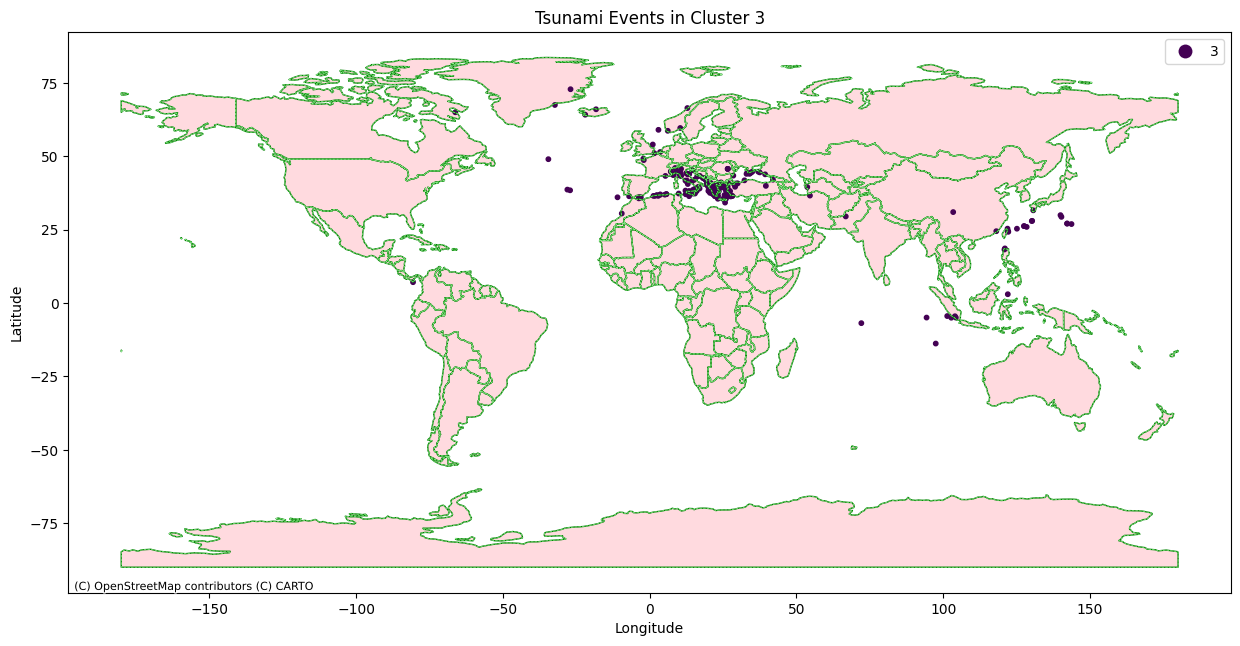

In [55]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 3  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

     Latitude  Longitude  Tsunami Cause Code  Cluster
650     18.00     -76.80                 1.0        4
656     -8.20     118.00                 6.0        4
671     19.10    -103.94                 1.0        4
678     19.67     145.40                 6.0        4
681     17.20     -99.60                 1.0        4


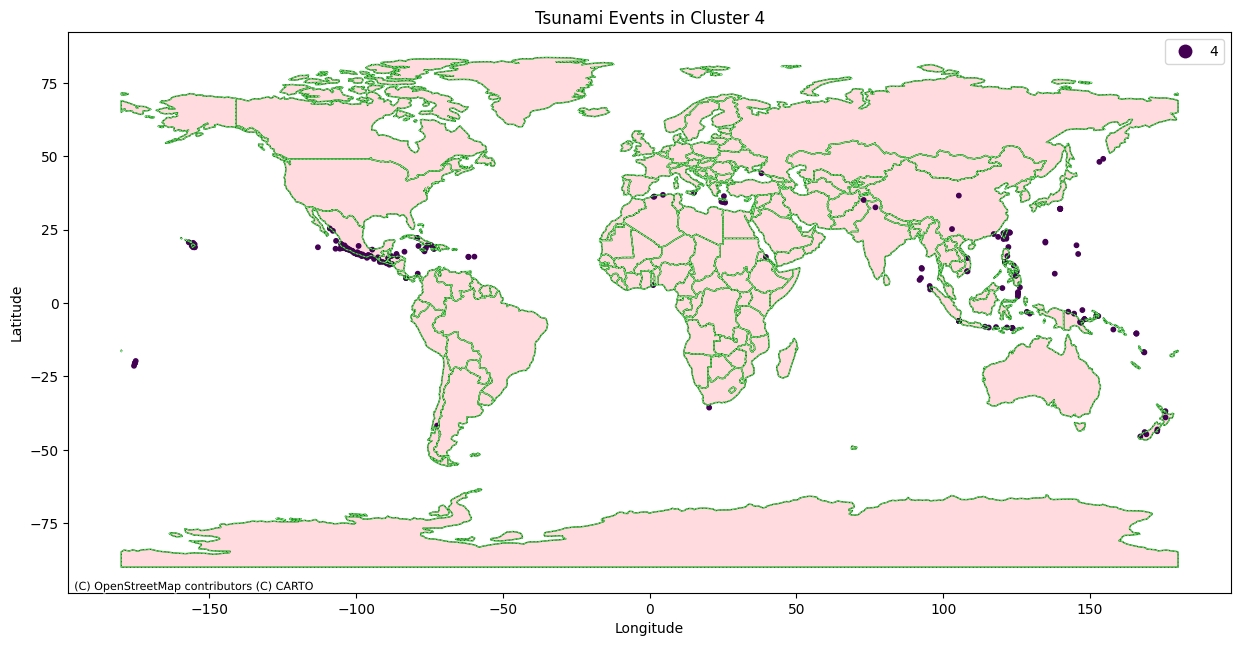

In [56]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 4  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [57]:
# Function to analyze and visualize the distribution of causes within each cluster
def analyze_cluster(tsunami_filtered):
    cluster_causes = tsunami_filtered.groupby('Cluster')['Tsunami Cause Code'].value_counts().unstack().fillna(0)
    cluster_causes.columns = [
        'Unknown', 'Earthquake', 'Questionable Earthquake', 'Earthquake and Landslide',
        'Volcano and Earthquake', 'Volcano, Earthquake, and Landslide', 'Volcano', 
        'Volcano and Landslide', 'Landslide', 'Meteorological', 'Explosion', 'Astronomical Tide'
    ]
    cluster_causes.plot(kind='bar', stacked=True, figsize=(15, 10), colormap='viridis')
    plt.title('Distribution of Tsunami Causes within Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Events')
    plt.legend(title='Tsunami Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Analyze and visualize the distribution of causes within each cluster
analyze_cluster(tsunami_filtered)

ValueError: Length mismatch: Expected axis has 11 elements, new values have 12 elements